## NON RIESCO A SALVARE LA TRASPARENZA DEI GRAFICI, RISOLVILO!

In [66]:
# Created on jan 2025
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012692

# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os


# Empirical data

In [67]:
data_dir = './' # data repo
res_dir = './results_1202/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
n_sub = 48
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90


In [68]:
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')



In [69]:
condition_0 = TS_CTR[:, 0:68, :] 
condition_0.shape 

(116, 68, 152)

In [70]:

# Example input array of shape (180, 718, 36)
#original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array_original = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array_original.shape)

n_sub = 47

New array shape: (48, 68, 152, 2)


In [71]:
# Define indices to remove
indices_to_remove = {0: 19, 1: 11}

# Use list comprehension to filter out the indices for each condition
new_array = np.stack([
    new_array_original[np.arange(48) != indices_to_remove[0], :, :, 0],  # Remove index 19 for condition 0
    new_array_original[np.arange(48) != indices_to_remove[1], :, :, 1]   # Remove index 11 for condition 1
], axis=-1)

print(new_array.shape)  # Should be (47, 68, 152, 2)


(47, 68, 152, 2)


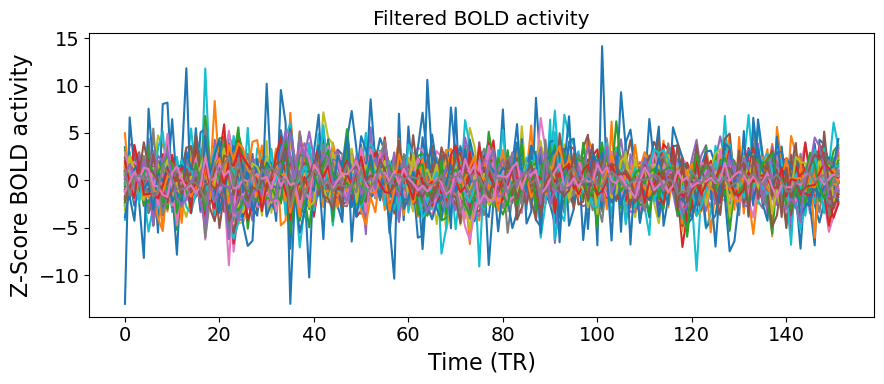

In [72]:
#All data plotted are stored in new_array
plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

Text(0.5, 1.0, 'FC0')

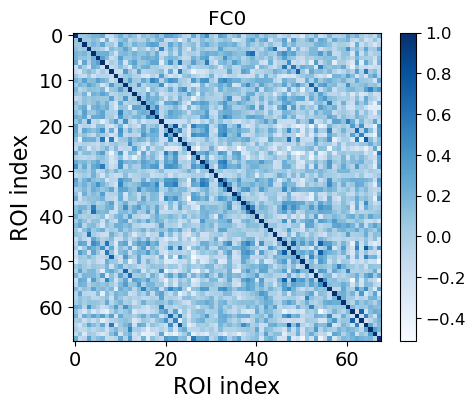

In [73]:
FC0 = np.corrcoef(new_array[1,:,:,1]) 
FC1 = FC0/np.max(FC0)
plt.figure(figsize=(5,4))
plt.imshow(FC1, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC0")

## Connectome mask

Use a high trashold for the Conectome and use an Or to combine Functional and Structural. Just to get the connectome playing a role.

In [74]:
# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.9 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = False # no self connection
    mask_ECS[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0



network size: 68
EC density: 0.017120280948200176


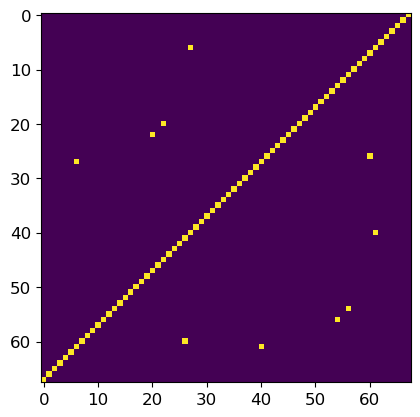

In [75]:
plt.imshow(mask_ECS)

In [76]:
SC = sio.loadmat('./SC_EnigmadK68.mat')

In [77]:
SC = sio.loadmat('./SC_EnigmadK68.mat')['matrix']

# MOU fitting to fMRI data

11 1
19 0
46 1

In [78]:
lim_FC = np.full((48, 2), 0.1)

'''
#outliers
lim_FC[11, 1] = 0.05
lim_FC[19, 0] = 0.05
'''
#good changes
lim_FC[23, 1] = 0.2
lim_FC[18, 1] = 0.2
lim_FC[45, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[45, 0] = 0.3
lim_FC[45, 1] = 0.2

'''
EPR is high: [15, 1]
EPR is high: [24, 1]
'''
lim_FC[15, 1] = 0.1
lim_FC[24, 1] = 0.1

# Create Functional Mask

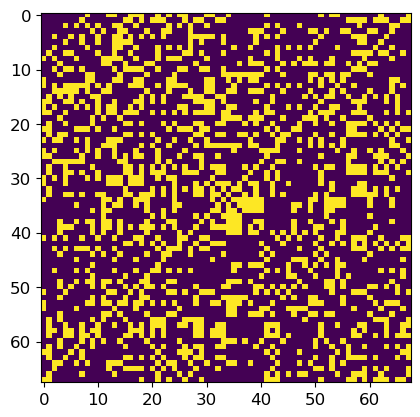

In [79]:

#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=47
n_cond=2
N=68
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections

plt.imshow(mask_ECF)


In [80]:
#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=47
n_cond=2
N=68
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.9 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = False # no self connection
    mask_ECS[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections
        
        mask_EC = np.logical_or(mask_ECS, mask_ECF).astype(int)
 
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_ECF, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)



network size: 68
EC density: 0.017120280948200176
sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 95, 'distance': np.float64(0.7661432834911104), 'correlation': np.float64(0.735406777537547), 'distance history': array([0.91027644, 0.90788178, 0.90552969, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.42523869, 0.43323628, 0.44106712, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7248400507908922), 'distFC1': np.float64(0.8075789347682952)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 35, 'distance': np.float64(0.8114780800589657), 'correlation': np.float64(0.6566428382782753), 'distance history': array([0.89350402, 0.88902935, 0.88523676, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.40505704, 0.43514997, 0.4621871 , ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.6990544107283141), 'distFC1': np.float64(0.9242423689314986)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations':

In [81]:
n_sub


47

In [82]:
fit_mod

array([[0.73540678, 0.65664284],
       [0.64314556, 0.61596936],
       [0.7599316 , 0.66804102],
       [0.69855032, 0.67716129],
       [0.68685891, 0.62388074],
       [0.66706815, 0.7220409 ],
       [0.67435173, 0.71241189],
       [0.74458594, 0.70081543],
       [0.61021342, 0.62102525],
       [0.68960326, 0.60771761],
       [0.66719535, 0.67108484],
       [0.6174334 , 0.64034615],
       [0.67951743, 0.7485209 ],
       [0.69340594, 0.70431356],
       [0.75614647, 0.60151538],
       [0.72251103, 0.5941253 ],
       [0.71074406, 0.65573839],
       [0.72821156, 0.67403137],
       [0.70319085, 0.72948983],
       [0.69204132, 0.71917942],
       [0.68566237, 0.62083035],
       [0.70240105, 0.68719498],
       [0.77642185, 0.6870239 ],
       [0.61158125, 0.63769429],
       [0.70190738, 0.56274119],
       [0.62416547, 0.71631027],
       [0.67644417, 0.71985899],
       [0.67532384, 0.6479491 ],
       [0.71205654, 0.64882223],
       [0.73046103, 0.6911658 ],
       [0.

In [83]:
n_sub = 47

Check that each participant has a goodness of fit higher then 0.55

In [84]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.55:
            print(i_sub, i_cond)

In [85]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


In [86]:
print("Files in results directory:", os.listdir(res_dir))


Files in results directory: ['Sigma_mod_try.npy', 'err_mod_try.npy', 'var_BOLD_try.npy', 'FC0_mod_try.npy', 'J_mod_try.npy', 'fit_mod_try.npy']


In [87]:
print("Saving results in:", os.path.abspath(res_dir))


Saving results in: /home/angelica/Desktop/EntropyProduction_MOUProcess/results_1202


In [88]:
n_sub

47

## Test goodness of fit

/tmp/ipykernel_19028/2703818930.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_19028/2703818930.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)


/tmp/ipykernel_19028/2703818930.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_19028/2703818930.py:38: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


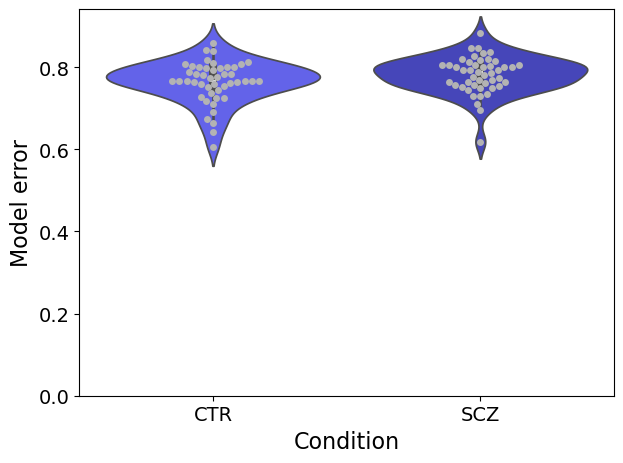

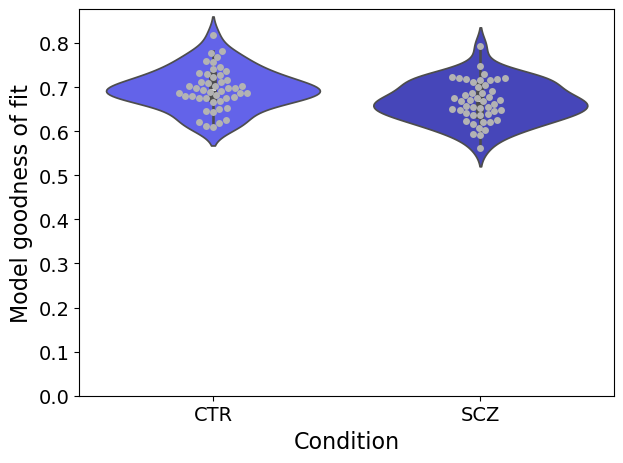

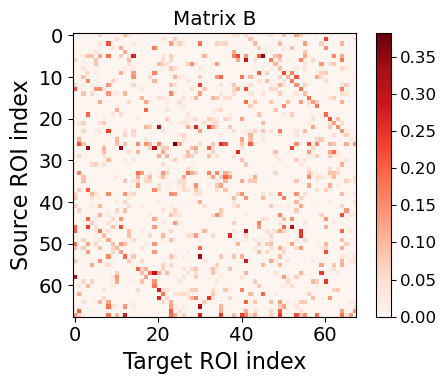

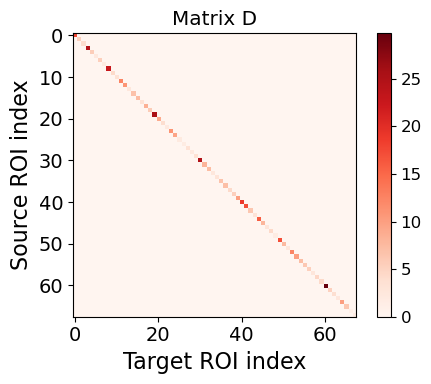

In [89]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')


# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix B')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix D')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [90]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)



In [91]:
n_sub

47

# Calculate Entropy Production of the fitted MOU

In [92]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate


        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(os.path.join(res_dir, f'EPR_try.npy'),EPR)



should be close to zero: 1.1013412404281553e-13
should be close to zero: 1.0658141036401503e-13
should be close to zero: 1.1368683772161603e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 2.7000623958883807e-13
should be close to zero: 1.4921397450962104e-13
should be close to zero: 7.105427357601002e-14
should be close to zero: 2.2737367544323206e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 4.8031023602845835e-14
should be close to zero: 2.3447910280083306e-13
should be close to zero: 3.552713678800501e-13
should be close to zero: 3.268496584496461e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 1.3677947663381929e-13
should be close to zero: 6.142308883738679e-14
should be close to zero: 3.979039320256561e-13
should be close to zero: 3.694822225952521e-13
should be close to zero: 5.5067062021407764e-14
should be close to zero: 2.2294666113253925e-13
should be close to zero: 1.4210854715202004e-1

Check if there are some strange high EPR values

In [93]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if abs(EPR[i_sub,i_cond]) > 10: print(f"EPR is high: {[i_sub, i_cond]}")

In [94]:
n_sub

47

In [95]:
EPR.shape

(47, 2)

/tmp/ipykernel_19028/389286898.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_19028/389286898.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


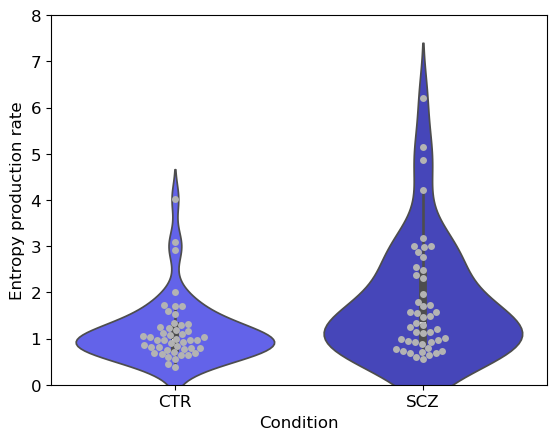

In [96]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_try.eps'), format='eps')

In [97]:
EPR.shape

(47, 2)

In [98]:
EPR_df

,sleep stage,EPR
0,CTR,0.772211
1,SCZ,3.001147
2,CTR,0.962673
3,SCZ,2.767040
4,CTR,3.089407
...,...,...
89,SCZ,0.935239
90,CTR,1.110229
91,SCZ,1.582530
92,CTR,1.541567


In [99]:
n_sub

47

In [100]:
len(EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist())

47

In [101]:
len(EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist())

47

## Statistical significance test 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Statistical Test Results:
Mann-Whitney U test statistic: 755.00
p-value: 0.008
statistically significant difference between the distributions of the two groups


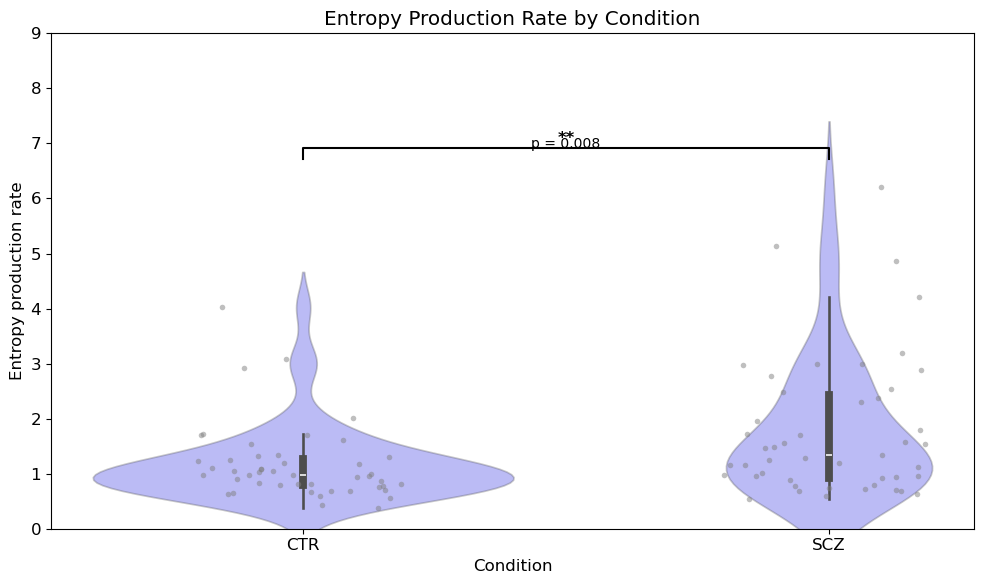

In [102]:
#trial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 0.5  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.2, bar_height + 0.2, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height + 0.25, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height + 0.15, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

'''
# Adjust layout
plt.show()
'''

plt.savefig(os.path.join(res_dir, f'EPR_stat_test.eps'), format='eps')

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

In [103]:
n_sub

47

## Calculate matrix X for each patient in each condition -> vector

Get X per partecipant and condition

Compare the trace of X with N 

Sum the values of the the rows of the matrix X you get a vector, if you see how far each component of the vector is from 1 characterized to far of equilibrium.

1. Matrix X 

2. Check if it is symm

3. Verctor for brain region (rows and columns)

4. Store the vectors in a matrix for each condition (68x48)

In [104]:
N=68

def is_symmetric(A, tol=1e-10):
    """Checks if matrix A is symmetric within numerical tolerance"""
    if A.shape[0] != A.shape[1]:  # Must be square
        return False
    return np.allclose(A, A.T, atol=tol)

# If we have an equilibrium process X = identity, trX = N, V=np.one(N)
def compute_X(B, D, S):
    D_pinv = np.linalg.pinv(D)  # Compute pseudoinverse of D
    
    # Compute (D_pinv * B * S)
    intermediate_matrix = np.dot(np.dot(D_pinv, B), S)
    
    # Compute X = (D_pinv * B * S)^{-1}
    X = np.linalg.inv(intermediate_matrix)  # Regular inverse here

    return X

X_indiv = np.zeros([n_sub,n_cond,N,N])
X_tr = np.zeros([n_sub,n_cond])
X_typ = np.zeros([n_sub,n_cond])
X_sym = np.zeros([n_sub, n_cond], dtype=bool)
V_indiv = np.zeros([n_sub, n_cond, N]) 
V_dist = np.zeros([n_sub, n_cond, N]) # absolute distance of each component of V from 1

for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
        D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
        S = np.copy(FC0_mod[i_sub,i_cond,:,:])

        X = compute_X(B, D, S)
        X_tr[i_sub, i_cond] = X.trace()
        X_typ[i_sub, i_cond] = X.trace()/float(N)
        X_indiv[i_sub,i_cond,:,:] = X
        X_sym[i_sub, i_cond] = is_symmetric(X)

        V = X.sum(axis=1).reshape(-1, 1)
        abs_distance = np.abs(V - 1)
        V_indiv[i_sub, i_cond, :] = V[:, 0]
        V_dist[i_sub, i_cond, :] = abs_distance[:, 0]

#print(X_typ)

/tmp/ipykernel_19028/3073348643.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
/tmp/ipykernel_19028/3073348643.py:22: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)


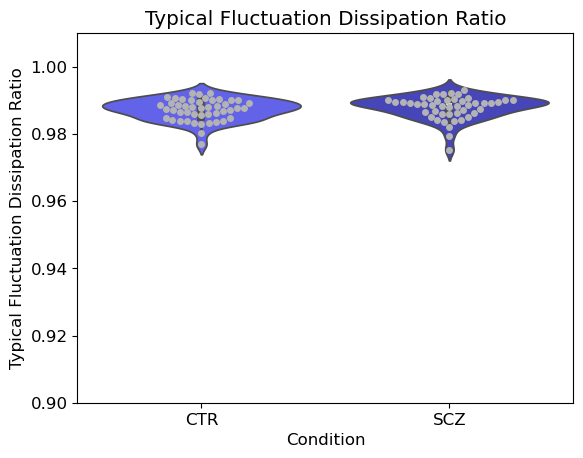

In [105]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

X_typ_tmp = dict()
X_typ_tmp['condition'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
X_typ_tmp['X_typ'] = X_typ.flatten()

X_typ_df = pd.DataFrame(X_typ_tmp)

X_typ_df=X_typ_df.drop(index=13)


# real data

plt.figure()
ax = sb.violinplot(data=X_typ_df, x='condition', y='X_typ', palette=cols)
sb.swarmplot(data=X_typ_df, x='condition', y='X_typ', color=[0.7,0.7,0.7])
plt.axis(ymin=0.9, ymax=1.01)
plt.title("Typical Fluctuation Dissipation Ratio")
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Typical Fluctuation Dissipation Ratio', fontsize=12)

plt.savefig(os.path.join(res_dir, f'typical_FDR.eps'), format='eps')

# Analyzing the vector V

In [106]:
#PLOTS GRAPHS FOR EACH BRAIN REGION: 

'''
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

# Create a separate violin plot for each component

for i in range(N):
    plt.figure(figsize=(6, 4))
    
    # Extract data for the specific component across conditions and subjects
    V_component = V_indiv[:, :, i]  # Shape (n_sub, n_cond)
    
    # Create DataFrame for violin plot
    V_component_tmp = {
        'Condition': np.tile(conds, n_sub),
        'V_indiv': V_component.flatten()
    }
    
    V_component_df = pd.DataFrame(V_component_tmp)

    # Violin plot
    sb.violinplot(data=V_component_df, x='Condition', y='V_indiv', inner=None, palette=cols)
    sb.swarmplot(data=V_component_df, x='Condition', y='V_indiv', color=[0.7,0.7,0.7], alpha=0.7)

    # Formatting the plot
    plt.xlabel("Condition")
    plt.ylabel("V_indiv Value")
    plt.title(f"V_indiv for Component {i} Across Conditions")
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.tight_layout()
    plt.show()
'''

'\ncols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]\ncols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]\n\n# Create a separate violin plot for each component\n\nfor i in range(N):\n    plt.figure(figsize=(6, 4))\n    \n    # Extract data for the specific component across conditions and subjects\n    V_component = V_indiv[:, :, i]  # Shape (n_sub, n_cond)\n    \n    # Create DataFrame for violin plot\n    V_component_tmp = {\n        \'Condition\': np.tile(conds, n_sub),\n        \'V_indiv\': V_component.flatten()\n    }\n    \n    V_component_df = pd.DataFrame(V_component_tmp)\n\n    # Violin plot\n    sb.violinplot(data=V_component_df, x=\'Condition\', y=\'V_indiv\', inner=None, palette=cols)\n    sb.swarmplot(data=V_component_df, x=\'Condition\', y=\'V_indiv\', color=[0.7,0.7,0.7], alpha=0.7)\n\n    # Formatting the plot\n    plt.xlabel("Condition")\n    plt.ylabel("V_indiv Value")\n    plt.title(f"V_indiv for Component {i} Across Conditions")\n    plt.grid(True, lin

By choosing i you can choose the brain region you want to plot

/tmp/ipykernel_19028/3884938567.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=V_component_df, x='Condition', y='V_indiv', inner=None, palette=cols)
/tmp/ipykernel_19028/3884938567.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=V_component_df, x='Condition', y='V_indiv', inner=None, palette=cols)


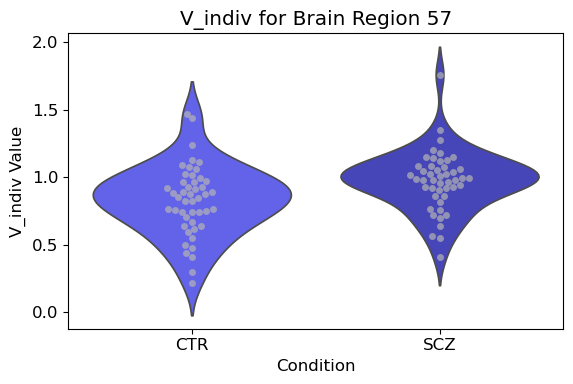

In [107]:
#Choose the brain region:
i = 57

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

plt.figure(figsize=(6, 4))

# Extract data for the specific component across conditions and subjects
V_component = V_indiv[:, :, i]  # Shape (n_sub, n_cond)

# Create DataFrame for violin plot
V_component_tmp = {
    'Condition': np.tile(conds, n_sub),
    'V_indiv': V_component.flatten()
}

V_component_df = pd.DataFrame(V_component_tmp)
# Violin plot
sb.violinplot(data=V_component_df, x='Condition', y='V_indiv', inner=None, palette=cols)
sb.swarmplot(data=V_component_df, x='Condition', y='V_indiv', color=[0.7,0.7,0.7], alpha=0.7)
# Formatting the plot
plt.xlabel("Condition")
plt.ylabel("V_indiv Value")
plt.title(f"V_indiv for Brain Region {i}")
#plt.grid(True, linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()
plt.show()

In [108]:
n_sub

47

In [120]:
# Compute mean and standard deviation over n_sub
V_mean = np.mean(V_indiv, axis=0)  # Shape [n_cond, N]
V_std = np.std(V_indiv, axis=0)  # Shape [n_cond, N]

V_mean_ctr = V_mean[0, :]
V_mean_scz = V_mean[1, :]
V_std_ctr = V_std[0, :]
V_std_scz = V_std[1, :]

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'V_mean_ctr.npy'),V_mean_ctr)
np.save(os.path.join(res_dir, f'V_mean_scz.npy'),V_mean_scz)
np.save(os.path.join(res_dir, f'V_std_ctr.npy'),V_std_ctr)
np.save(os.path.join(res_dir, f'V_std_scz.npy'),V_std_scz)

In [127]:
print(V_mean.shape)
print(V_std.shape)

(2, 68)
(2, 68)


In [128]:
np.save(os.path.join(res_dir, f'V_mean.npy'),V_mean)
np.save(os.path.join(res_dir, f'V_std.npy'),V_std)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


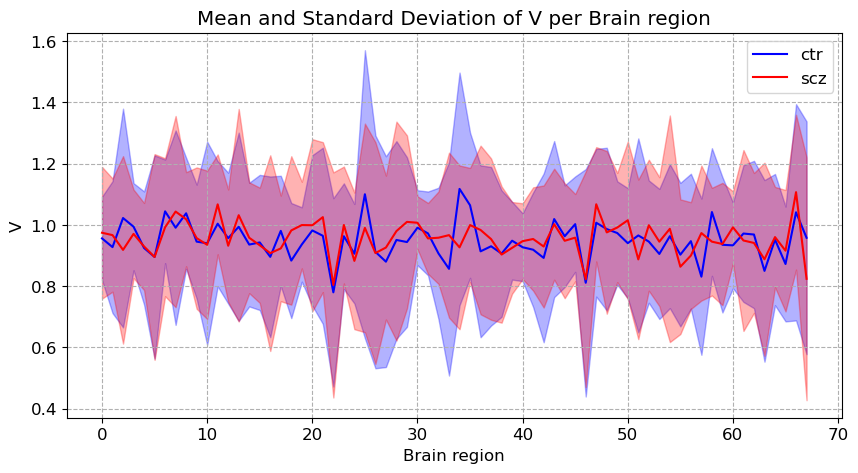

In [142]:
# X-axis values
x = np.arange(N)

# color palette
cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]

# Create the plot
plt.figure(figsize=(10, 5))

# Plot for control group
plt.plot(x, V_mean[0, :], label="ctr", color="blue")
plt.fill_between(x, V_mean[0, :] - V_std[0, :], V_mean[0, :] + V_std[0, :], color="blue", alpha=0.3)

# Plot for schizophrenia group
plt.plot(x, V_mean[1, :], label="scz", color="red")
plt.fill_between(x, V_mean[1, :] - V_std[1, :], V_mean[1, :] + V_std[1, :], color="red", alpha=0.3)

# Labels and legend
plt.xlabel("Brain region")
plt.ylabel("V")
plt.title("Mean and Standard Deviation of V per Brain region")
plt.legend()
plt.grid(True, linestyle='--')

# Show the plot
plt.savefig(os.path.join(res_dir, f'V_mean_std.eps'), format='eps')

## Robust statistical test: multiple comparison test -> find the brain regions of interest

- STATISTICAL MULTITEST:

bonferroni : one-step correction

sidak : one-step correction

holm-sidak : step down method using Sidak adjustments

holm : step-down method using Bonferroni adjustments

simes-hochberg : step-up method (independent)

hommel : closed method based on Simes tests (non-negative)

fdr_bh : Benjamini/Hochberg (non-negative)

fdr_by : Benjamini/Yekutieli (negative)

fdr_tsbh : two stage fdr correction (non-negative)

fdr_tsbky : two stage fdr correction (non-negative)


- How to choose the appropriate STATISTICAL TEST:

Bonferroni = reduces at the minimum the type I errors (type I = detects a significant difference when none actually exists), this maximize the type II errors (type II = there is some significant difference that gets ignored). It consists in dividing the original p-value threshold alpha by the number of tests. 
IT ENSURES ALMOST 0 TYPE I ERRORS

FDR_BH = better balance between Type I and Type II errors, allows some false positives but controls their proportion. 

Bonferroni eliminates false positives but at the cost of missing real effects.
FDR-BH finds more true effects while allowing a small number of false positives.
FDR-BH better for our case.

If you include the correction it doesn't show any statistical difference. Even if you try with other multitests. 

If we don't include the correction we get 4 regions. There is a high risk of type I errors in this case. 

In [110]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Initialize lists to store results
p_values = []

# Iterate over each brain region
for i in range(N):
    # Extract data for the current brain region
    group_0 = V_indiv[:, 0, i]  # Control group
    group_1 = V_indiv[:, 1, i]  # Schizophrenic group

    p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue    
    p_values.append(p)

# Convert p-values to numpy array
p_values = np.array(p_values)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region Index": np.arange(N),
    "p-value": p_values,
    "corrected p-value": p_corrected
})

# Filter significant brain regions
significant_regions = results_df[results_df["corrected p-value"] < 0.05]
significant_uncorrected = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Extract and print significant brain regions
significant_brain_regions = significant_regions["Brain Region Index"].tolist()
significant_brain_uncorrected = significant_uncorrected["Brain Region Index"].tolist()

print("\nBrain regions of interest (statistically significant differences after FDR correction):")
print(significant_brain_regions)
print("\nBrain regions of interest (statistically significant differences using NO correction, but alpha=0.01):")
print(significant_brain_uncorrected)

np.save(os.path.join(res_dir, f'V_corr.npy'),results_df)



Statistical Analysis Results:


Brain regions of interest (statistically significant differences after FDR correction):
[]

Brain regions of interest (statistically significant differences using NO correction, but alpha=0.01):
[34, 57]


In [111]:
n_sub

47

In [112]:
# Initialize lists to store results for each (i, j) brain region pair
p_values_list = []
region_1_list = []
region_2_list = []

# Iterate over each (i, j) pair, considering all entries (not just upper triangle)
for i in range(N):
    for j in range(N):  # Now including the full NxN matrix (not assuming symmetry)
        # Extract data for the current brain region interaction (i, j)
        group_0 = X_indiv[:, 0, i, j]  # Control group
        group_1 = X_indiv[:, 1, i, j]  # Schizophrenic group

        p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided').pvalue

        # Store results
        p_values_list.append(p)
        region_1_list.append(i)
        region_2_list.append(j)

# Convert p-values to numpy array for multiple comparison correction
p_values_array = np.array(p_values_list)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected, _, _ = smm.multipletests(p_values_array, alpha=0.05, method='fdr_bh')

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list,
    "corrected p-value": p_corrected
})

# Filter significant brain region pairs based on FDR correction
significant_interactions = results_df[results_df["corrected p-value"] < 0.05]
significant_interactions_nocorr = results_df[results_df["p-value"] < 0.01]

# Print results
print("\nStatistical Analysis Results:\n")
#print(results_df)

# Convert DataFrame to dictionary
results_dict = results_df.to_dict(orient="list")

# Save dictionary as a .npy file
np.save("X_corr.npy", results_dict)

print("\nSignificant Brain Region Pairs (statistically significant interactions after correction):")
#(significant_interactions[["Brain Region 1", "Brain Region 2"]].values.tolist())
print(len(significant_interactions[["Brain Region 1", "Brain Region 2"]].values.tolist()))
print("\nSignificant Brain Region Pairs (statistically significant interactions after NO correction but alpha = 0.01):")
#print(significant_interactions_nocorr[["Brain Region 1", "Brain Region 2"]].values.tolist())
print(len(significant_interactions_nocorr[["Brain Region 1", "Brain Region 2"]].values.tolist()))


Statistical Analysis Results:


Significant Brain Region Pairs (statistically significant interactions after correction):
0

Significant Brain Region Pairs (statistically significant interactions after NO correction but alpha = 0.01):
46


No results after the correction, even by trying different methods. 

I get results with a strict p-value threshold, but there's high risk of type I errors


# Now we get a matrix for each condition and do the statistical test on it: 

NB. IT SHOULD BE OKAY DOING IT, BUT WE LOOSE INFORMATION LIKE THIS RIGHT?

In [113]:
# Compute mean and standard deviation matrices for each condition

# Initialize matrices to store the results
mean_matrices = np.zeros((n_cond, N, N))
std_matrices = np.zeros((n_cond, N, N))

# Iterate over each condition (control and schizophrenia)
for cond in range(n_cond):
    mean_matrices[cond] = np.mean(X_indiv[:, cond, :, :], axis=0)  # Mean over subjects
    std_matrices[cond] = np.std(X_indiv[:, cond, :, :], axis=0, ddof=1)  # Standard deviation over subjects

# Store results in dictionary format for easy access
results = {
    "Mean Matrices": mean_matrices,
    "Standard Deviation Matrices": std_matrices
}

# Save results as numpy arrays for download
mean_filename = "./results/mean_matrices.npy"
std_filename = "./results/std_matrices.npy"
np.save(mean_filename, mean_matrices)
np.save(std_filename, std_matrices)

# Provide file links for download
print(f"\nMean matrices saved to: {mean_filename}")
print(f"Standard deviation matrices saved to: {std_filename}")


Mean matrices saved to: ./results/mean_matrices.npy
Standard deviation matrices saved to: ./results/std_matrices.npy


In [130]:
mean_matrices.shape
np.save(os.path.join(res_dir, f'X_mean.npy'),mean_matrices)

In [131]:
std_matrices.shape
np.save(os.path.join(res_dir, f'X_std.npy'),std_matrices)

In [123]:
X_mean_ctr = mean_matrices[0, :, :]
X_std_ctr = std_matrices[0, :, :]
X_mean_scz = mean_matrices[1, :, :]
X_std_scz = std_matrices[1, :, :]

#print
print(X_mean_scz.shape)
print(X_mean_ctr.shape)
print(X_std_scz.shape)
print(X_std_ctr.shape)

# Save each vector as a separate .npy file
np.save(os.path.join(res_dir, f'X_mean_ctr.npy'),X_mean_ctr)
np.save(os.path.join(res_dir, f'X_mean_scz.npy'),X_mean_scz)
np.save(os.path.join(res_dir, f'X_std_ctr.npy'),X_std_ctr)
np.save(os.path.join(res_dir, f'X_std_scz.npy'),X_std_scz)

(68, 68)
(68, 68)
(68, 68)
(68, 68)


In [114]:
from scipy.stats import ttest_ind_from_stats
import statsmodels.stats.multitest as smm

def welch_t_test_scipy(mean_matrices, std_matrices, n_1, n_2):
    # Extract means and standard deviations
    mean_1, mean_2 = mean_matrices[0], mean_matrices[1]
    std_1, std_2 = std_matrices[0], std_matrices[1]

    # Compute Welch’s t-test for each element using scipy (vectorized)
    t_values, p_values = ttest_ind_from_stats(mean1=mean_1, std1=std_1, nobs1=n_1,
                                              mean2=mean_2, std2=std_2, nobs2=n_2,
                                              equal_var=False)

    # Apply FDR correction
    _, p_values_corrected, _, _ = smm.multipletests(p_values.flatten(), method='fdr_bh')
    p_values_corrected = p_values_corrected.reshape(mean_1.shape)  # Reshape back

    return t_values, p_values, p_values_corrected

# Example usage
n_1 = 47  # Number of samples in group 1
n_2 = 47  # Number of samples in group 2

t_values, p_values, p_values_corrected = welch_t_test_scipy(mean_matrices, std_matrices, n_1, n_2)

# Identify significant elements
significant_elements = p_values_corrected < 0.05
significant_elements_nocorr = p_values < 0.01

# Print the number of significant elements
print(f"Number of significant elements after correction: {np.sum(significant_elements)}")
print(f"Number of significant elements after NO correction: {np.sum(significant_elements_nocorr)}")

# Get indices of significant values (row, col format)
'''
indices = np.argwhere(p_values < 0.01)
for i, j in indices:
    print(f"[{i}, {j}]")
'''

Number of significant elements after correction: 0
Number of significant elements after NO correction: 43


'\nindices = np.argwhere(p_values < 0.01)\nfor i, j in indices:\n    print(f"[{i}, {j}]")\n'

# Linear Response

By changing i_cond and i_sub you get the response of the patient that you want

max time and time step:  TT= 30 and dt=0.1

latency: [1.1 4.2 2.6 2.4 2.6 2.9 1.8 2.9 1.1 3.8 2.2 2.7 2.3 2.2 2.4 5.  3.6 2.4
 3.2 2.8 4.7 4.7 5.  1.  3.1 4.2 3.7 4.  3.6 2.7 2.9 3.5 3.9 4.2 4.7 2.5
 3.3 3.8 2.5 3.6 1.4 1.1 3.8 2.3 2.5 2.5 4.2 0.  2.1 1.  4.7 4.4 3.8 2.3
 1.  3.2 4.8 3.4 3.6 3.9 2.7 4.4 2.2 4.3 1.  2.7 3.8 4.1], auc: [0.01640157 0.00178461 0.0035986  0.00657114 0.00112088 0.00167383
 0.00551269 0.00228458 0.02233525 0.00135591 0.0018657  0.00428398
 0.00476292 0.00656156 0.00222518 0.00083761 0.00239648 0.01049805
 0.0037385  0.00655267 0.00062243 0.0010247  0.00035894 0.01863887
 0.00364758 0.00101531 0.00108947 0.00173034 0.00185603 0.00455697
 0.00383578 0.00162467 0.00217791 0.00132499 0.00041238 0.0033798
 0.00067747 0.00071041 0.00304521 0.0014349  0.00819362 0.00795317
 0.00170815 0.00268836 0.00400195 0.0011508  0.00039529 0.08936583
 0.00125757 0.0186042  0.00057276 0.00050968 0.00152837 0.00139744
 0.00423331 0.00067165 0.00125612 0.00111825 0.00083814 0.00216567
 0.00412225 0.0013819  0.00185281 0.000

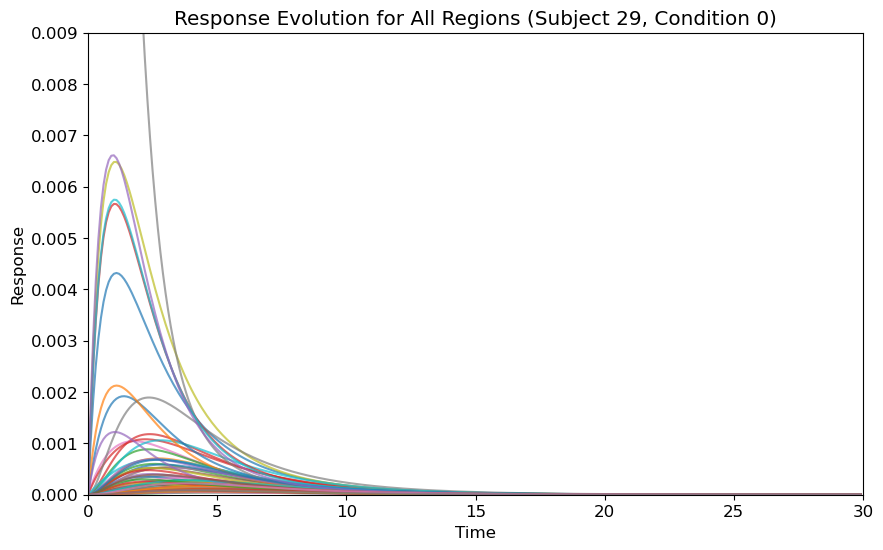

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson

# ParametersV_indiv, axis=0) 
i_cond = 0  # Choose in [0,1]
i_sub = 29   # Choose in [0, 47]
TT = 30      # Maximum time
dt = 0.1    # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68

# Initialize response function
p = np.zeros(N)
i_reg = 47  # Example region, but we compute for all
p[i_reg] = 0.1
res = np.zeros((len(time_points), N))

# Matrix B
B = np.copy(-J_mod[i_sub, i_cond, :, :].T)

# Compute the response function over finer time resolution
for i, t in enumerate(time_points):
    res[i, :] = np.matmul(expm(-B * t), p)

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=0)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=0)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency}, auc: {auc}')

# Plot results for all regions
plt.figure(figsize=(10, 6))
for region in range(N):
    plt.plot(time_points, res[:, region], alpha=0.7, label=f'Region {region}')

plt.ylim([0, 0.009])  # Adjust y-axis for better visualization
plt.xlim([0, TT])
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"Response Evolution for All Regions (Subject {i_sub}, Condition {i_cond})")
plt.show()


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import simpson

# Parameters
TT = 30      # Maximum time
dt = 0.1     # Smaller time step for higher resolution
time_points = np.arange(0, TT, dt)  # High-resolution time grid
N = 68
num_time_steps = len(time_points)

# Initialize results array
res = np.zeros((n_sub, n_cond, N, num_time_steps, N))

# Loop over subjects and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        B = -J_mod[i_sub, i_cond, :, :].T  # Precompute B matrix once
        expm_B_t = np.array([expm(-B * t) for t in time_points])  # Compute all exponentials at once
        
        for i_reg in range(N):
            p = np.zeros(N)
            p[i_reg] = 0.1  # Initial condition at index i
            res[i_sub, i_cond, i_reg, :, :] = np.matmul(expm_B_t, p)  # Correct matrix-vector multiplication

# Compute latency and AUC for each region
latency = time_points[np.argmax(res, axis=3)]  # Convert index to actual time
auc = simpson(res, dx=dt, axis=3)  # Adjust dx to match new time step

# Print results
print(f'latency: {latency.shape}, auc: {auc.shape}')

latency: (47, 2, 68, 68), auc: (47, 2, 68, 68)


Latency (i_sub, i_cond, perturbed region, response region)

AUC (i_sub, i_cond, perturbed region, response region)

how the code was sped up: 

1. precompute exp(-B*t) before looping. 
2. efficient matrix-vector multiplication: np.matmul(expm_B_t,p) all time ponts in one go
3. use vectorized NumPy Operations for Latency and AUC

In [117]:
#print(latency)

## Statistical test on latency and auc

In [124]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as smm
import pandas as pd

# Parameters
n_sub = 47  # Number of patients per condition
N = 68  # Brain regions

# Initialize lists to store results for each (i, j) brain region pair
p_values_list_latency = []
test_used_list_latency = []
p_values_list_auc = []
test_used_list_auc = []
region_1_list = []
region_2_list = []

# Perform statistical tests for each (i, j) region pair
for i in range(N):
    for j in range(N):
        try:
            # Extract data for the two conditions
            group_0_latency = latency[:, 0, i, j]  # Control group
            group_1_latency = latency[:, 1, i, j]  # Schizophrenic group
            group_0_auc = auc[:, 0, i, j]
            group_1_auc = auc[:, 1, i, j]
        except IndexError:
            print(f"IndexError at (i={i}, j={j}) - Check latency and auc dimensions")
            continue
        
        # Check if the data has zero variance (all values are the same)
        if np.all(group_0_latency == group_0_latency[0]) or np.all(group_1_latency == group_1_latency[0]):
            p_latency = 1.0  # No difference if variance is zero
            test_used_latency = "Skipped (zero variance)"
        else:
            p_latency = stats.mannwhitneyu(group_0_latency, group_1_latency, alternative='two-sided').pvalue
            test_used_latency = "Mann-Whitney U"
        
        if np.all(group_0_auc == group_0_auc[0]) or np.all(group_1_auc == group_1_auc[0]):
            p_auc = 1.0  # No difference if variance is zero
            test_used_auc = "Skipped (zero variance)"
        else:
            p_auc = stats.mannwhitneyu(group_0_auc, group_1_auc, alternative='two-sided').pvalue
            test_used_auc = "Mann-Whitney U"
        
        # Store results
        p_values_list_latency.append(p_latency)
        test_used_list_latency.append(test_used_latency)
        p_values_list_auc.append(p_auc)
        test_used_list_auc.append(test_used_auc)
        region_1_list.append(i)
        region_2_list.append(j)

# Convert p-values to numpy array for multiple comparison correction
p_values_array_latency = np.array(p_values_list_latency)
p_values_array_auc = np.array(p_values_list_auc)

# Apply FDR correction (Benjamini-Hochberg)
_, p_corrected_latency, _, _ = smm.multipletests(p_values_array_latency, alpha=0.05, method='bonferroni')
_, p_corrected_auc, _, _ = smm.multipletests(p_values_array_auc, alpha=0.05, method='bonferroni')

# Store results in DataFrames
results_df_latency = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_latency,
    "corrected p-value": p_corrected_latency,
    "Test Used": test_used_list_latency
})

results_df_auc = pd.DataFrame({
    "Brain Region 1": region_1_list,
    "Brain Region 2": region_2_list,
    "p-value": p_values_list_auc,
    "corrected p-value": p_corrected_auc,
    "Test Used": test_used_list_auc
})

# Filter significant brain region pairs based on FDR correction
significant_latency = results_df_latency[results_df_latency["corrected p-value"] < 0.05]
significant_auc = results_df_auc[results_df_auc["corrected p-value"] < 0.05]

# Save results as .npy files
np.save(os.path.join(res_dir, f'latency.npy'), results_df_latency.to_dict(orient="list"))
np.save(os.path.join(res_dir, f'auc.npy'), results_df_auc.to_dict(orient="list"))

# Print results
print("\nSignificant Brain Region Pairs for Latency (after correction):")
print(len(significant_latency[["Brain Region 1", "Brain Region 2"]].values.tolist()))
print(significant_latency[["Brain Region 1", "Brain Region 2"]].values.tolist())
print("\nSignificant Brain Region Pairs for AUC (after correction):")
print(len(significant_auc[["Brain Region 1", "Brain Region 2"]].values.tolist()))
print(significant_auc[["Brain Region 1", "Brain Region 2"]].values.tolist())



Significant Brain Region Pairs for Latency (after correction):
77
[[0, 28], [3, 21], [4, 35], [4, 42], [5, 22], [5, 26], [7, 43], [8, 16], [9, 56], [11, 15], [11, 63], [15, 60], [17, 38], [18, 30], [19, 56], [19, 63], [22, 5], [22, 44], [22, 52], [22, 60], [28, 42], [30, 2], [30, 16], [30, 18], [32, 50], [32, 52], [33, 17], [34, 8], [35, 31], [35, 38], [36, 0], [36, 13], [36, 35], [36, 38], [38, 36], [39, 18], [39, 35], [39, 42], [44, 22], [44, 29], [44, 56], [47, 51], [48, 49], [49, 6], [50, 22], [50, 32], [50, 56], [52, 21], [52, 22], [52, 26], [52, 51], [52, 56], [52, 67], [54, 13], [54, 36], [55, 42], [56, 9], [56, 52], [56, 60], [57, 44], [57, 49], [57, 52], [57, 64], [60, 22], [60, 54], [61, 19], [61, 44], [61, 60], [62, 3], [62, 19], [63, 5], [63, 44], [63, 52], [63, 60], [67, 9], [67, 44], [67, 52]]

Significant Brain Region Pairs for AUC (after correction):
16
[[1, 16], [29, 67], [33, 67], [36, 29], [36, 42], [36, 67], [40, 67], [42, 29], [42, 34], [42, 67], [57, 18], [57, 21

Good, using BONFERRONI = conservative towards type I errors, I get some statistical significant results